<a href="https://colab.research.google.com/github/zahadev/data_analysis/blob/master/CustomersSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn import metrics

## Кластеризация

In [ ]:
bank = pd.read_csv("BankChurners.csv")

Мы разделим клиентов на группы на основании возраста, пола, образование, семейнего статуса, дохода, периода отношение с банком, кредитнего лимита, количеством транзакции и ушел ли клиент.

Что бы делать рекомендации более персонализированее.

In [ ]:
# оставим только нужные нам данные и переименуем колонок
bank = bank[['Attrition_Flag', 'Customer_Age', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Months_on_book', 'Credit_Limit', 'Total_Trans_Ct']]
bank.columns = ['att_flag', 'age', 'gender', 'edu_level', 'marital_status', 'income', 'months_on_book', 'credit_limit', 'total_trans_ct']
bank.head()

,att_flag,age,gender,edu_level,marital_status,income,months_on_book,credit_limit,total_trans_ct
0,Existing Customer,45,M,High School,Married,$60K - $80K,39,12691.0,42
1,Existing Customer,49,F,Graduate,Single,Less than $40K,44,8256.0,33
2,Existing Customer,51,M,Graduate,Married,$80K - $120K,36,3418.0,20
3,Existing Customer,40,F,High School,Unknown,Less than $40K,34,3313.0,20
4,Existing Customer,40,M,Uneducated,Married,$60K - $80K,21,4716.0,28


In [ ]:
#переобразуем категоральные данные на числовые
bank = pd.get_dummies(bank, drop_first = True)
bank.head()

,age,months_on_book,credit_limit,total_trans_ct,att_flag_Existing Customer,gender_M,edu_level_Doctorate,edu_level_Graduate,edu_level_High School,edu_level_Post-Graduate,edu_level_Uneducated,edu_level_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,income_$40K - $60K,income_$60K - $80K,income_$80K - $120K,income_Less than $40K,income_Unknown
0,45,39,12691.0,42,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
1,49,44,8256.0,33,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,51,36,3418.0,20,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,40,34,3313.0,20,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
4,40,21,4716.0,28,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0


Так как у нас есть разные по масштабу переменные, нужно их нормировать

In [ ]:
# нормируем данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_bank = scaler.fit_transform(bank)

После нескольких экспериментов, и подсчетов метрик выбрал иерахическая кластеризацию, точнее алгомеративный метод кластеризации. 

При построение кластера наилушим способом определение расстояние между кластерами оказалось *Averge Linkage*

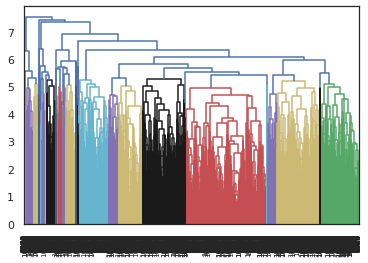

In [ ]:
mergings = linkage(scaled_bank, method='average')
dendrogram(mergings,
             leaf_rotation = 90,
             leaf_font_size = 7,
             )
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
amodel = AgglomerativeClustering(linkage='average', n_clusters =21)
amodel = amodel.fit(scaled_bank)
apred = amodel.labels_
apred

array([4, 1, 5, ..., 1, 3, 1])

In [ ]:
res = bank.copy()
res["cluster"] = amodel.labels_
res.groupby("cluster").mean()

,age,months_on_book,credit_limit,total_trans_ct,att_flag_Existing Customer,gender_M,edu_level_Doctorate,edu_level_Graduate,edu_level_High School,edu_level_Post-Graduate,edu_level_Uneducated,edu_level_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,income_$40K - $60K,income_$60K - $80K,income_$80K - $120K,income_Less than $40K,income_Unknown
cluster,,,,,,,,,,,,,,,,,,,,
0,47.460993,36.947991,8334.625532,63.650118,0.789598,0.425532,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.484634,0.430260,0.0,0.158392,0.125296,0.130024,0.349882,0.153664
1,46.556967,36.145296,3779.779992,66.253275,0.836443,0.081778,0.0,0.415244,0.247320,0.0,0.000000,0.211592,0.492656,0.434299,0.0,0.000000,0.000000,0.000000,0.990075,0.001191
2,45.498938,35.318471,8593.454989,65.195329,0.830149,0.481953,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.511677,0.401274,0.0,0.222930,0.157113,0.140127,0.335456,0.087049
3,46.308511,35.821809,5707.666489,69.172872,0.821809,0.265957,0.0,0.345745,0.196809,0.0,0.223404,0.154255,0.000000,0.000000,1.0,0.321809,0.000000,0.047872,0.595745,0.000000
4,45.957976,35.536878,10596.796055,63.438250,0.873070,1.000000,0.0,0.331904,0.244425,0.0,0.155232,0.163808,0.518010,0.402230,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
5,47.062500,36.661990,16877.929911,62.220663,0.839923,1.000000,0.0,0.412628,0.263393,0.0,0.000000,0.179209,0.541454,0.389668,0.0,0.000000,0.002551,0.687500,0.007015,0.000000
6,45.534884,34.837209,11853.293023,64.418605,0.720930,0.558140,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.139535,0.069767,0.348837,0.255814,0.116279
7,46.301087,35.780435,9409.070652,66.214130,0.833696,0.043478,0.0,0.333696,0.223913,0.0,0.189130,0.150000,0.471739,0.438043,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
8,44.538462,34.515385,18012.863846,63.646154,0.884615,1.000000,0.0,0.300000,0.300000,0.0,0.007692,0.253846,0.000000,0.000000,1.0,0.000000,0.000000,0.776923,0.000000,0.000000


У нас получилось 21 отдельных кластеров. 
Есть интересный кластер(17) где собрались ушедшие клиенты, они все женщины и средний возраст 62 и являются клиентами банка в среднем 56. 
Но, я решил посмотреть сколько элементов содержится в каждом кластере:

In [ ]:
# считаем количество элементов
res.groupby("cluster")["age"].count()

cluster
0      423
1     2519
2      471
3      376
4     1166
5     1568
6       43
7      920
8      130
9       28
10      71
11       1
12      10
13       1
14    1017
15       2
16       7
17       1
18       6
19    1274
20      93
Name: age, dtype: int64


Оказалось в 17 кластере 1 элемент. И вообще есть 3 кластера с 1 элементом. И я решил воспользоваться методом DBSCAN который отбрасывает такие данные. 

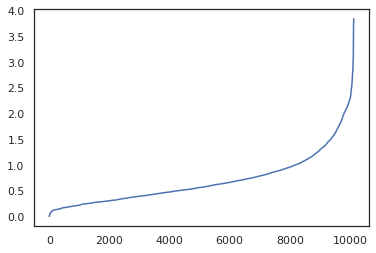

In [ ]:
# посчитаем eps
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_bank)
distances, indices = nbrs.kneighbors(scaled_bank)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
dbmodel = DBSCAN(eps=2.9, min_samples=6)
dbmodel = dbmodel.fit(scaled_bank)
dbpred = dbmodel.labels_

res = bank.copy()
res["cluster"] = dbmodel.labels_
res.groupby("cluster").mean()

,age,months_on_book,credit_limit,total_trans_ct,att_flag_Existing Customer,gender_M,edu_level_Doctorate,edu_level_Graduate,edu_level_High School,edu_level_Post-Graduate,edu_level_Uneducated,edu_level_Unknown,marital_status_Married,marital_status_Single,marital_status_Unknown,income_$40K - $60K,income_$60K - $80K,income_$80K - $120K,income_Less than $40K,income_Unknown
cluster,,,,,,,,,,,,,,,,,,,,
-1,44.655556,34.122222,13612.986667,59.555556,0.500000,0.644444,0.266667,0.022222,0.033333,0.366667,0.155556,0.133333,0.100000,0.055556,0.822222,0.188889,0.166667,0.144444,0.088889,0.266667
0,46.382906,35.992723,8476.431569,64.539428,0.844536,0.522228,0.000000,0.342816,0.218709,0.000000,0.159301,0.167637,0.503043,0.419291,0.000000,0.196613,0.155200,0.169092,0.397327,0.000000
1,45.734280,35.367140,8731.366329,68.434077,0.866126,0.452333,0.000000,0.344828,0.227181,0.000000,0.152130,0.174442,0.000000,0.000000,1.000000,0.235294,0.000000,0.233266,0.456389,0.000000
2,46.134831,36.101124,10962.111236,62.011236,0.887640,1.000000,0.000000,0.370787,0.247191,0.000000,0.146067,0.123596,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,45.435028,35.186441,7884.603672,65.293785,0.836158,0.420904,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.536723,0.392655,0.000000,0.293785,0.000000,0.186441,0.449153,0.000000
4,46.371336,35.832790,9352.082519,66.079262,0.834962,0.045603,0.000000,0.336591,0.222584,0.000000,0.188925,0.148751,0.473398,0.437568,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,46.862745,36.568627,10341.450980,60.294118,0.921569,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.431373,0.509804,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
6,47.349835,36.702970,7590.307921,64.821782,0.778878,0.402640,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.481848,0.429043,0.000000,0.221122,0.000000,0.181518,0.488449,0.000000
7,45.486486,36.243243,10433.251351,71.567568,0.972973,0.027027,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.486486,0.405405,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
res.groupby("cluster")["age"].count()

cluster
-1       90
 0     7558
 1      493
 2       89
 3      354
 4      921
 5       51
 6      303
 7       37
 8       64
 9       74
 10       8
 11      66
 12      10
 13       9
Name: age, dtype: int64

Получилось 14 кластеров. 1 большой и 13 маленьких. 

Можем видеть 3 кластера(13,11,7) с наибольшем количеством транзакции и там больше всего женщины.

Еще есть интересная небольшая группа(10) которая состоит из ушедших клиентов, и они все мужчины, средний возраст которых 47 лет, они все магистранты или аспиранты по образованию и у них самый высокий кредитный лимит. Можно подумать над тем, что для этих людей размер кредитного лимита был не важным показателем при выборе банка. 


## Ассоциативные правила

Найдем закономерности на основе характеристик клиентов

In [ ]:
# оставляем нужные нам данные
bank_cat = pd.read_csv("BankChurners.csv")
bank_cat = bank_cat[['Attrition_Flag', 'Customer_Age', 'Gender', 'Marital_Status', 'Income_Category', 'Months_on_book', 'Credit_Limit', 'Total_Trans_Ct']]
bank_cat.columns = ['att_flag', 'age', 'gender', 'marital_status', 'income', 'months_on_book', 'credit_limit', 'total_trans_ct']
bank_cat.head()

,att_flag,age,gender,marital_status,income,months_on_book,credit_limit,total_trans_ct
0,Existing Customer,45,M,Married,$60K - $80K,39,12691.0,42
1,Existing Customer,49,F,Single,Less than $40K,44,8256.0,33
2,Existing Customer,51,M,Married,$80K - $120K,36,3418.0,20
3,Existing Customer,40,F,Unknown,Less than $40K,34,3313.0,20
4,Existing Customer,40,M,Married,$60K - $80K,21,4716.0,28


In [ ]:
# числовые переменные переобразуем на категоральные
bank_cat["age"] = pd.cut(bank_cat["age"], bins = [18, 30, 50, 70, 100], right = False)
bank_cat["months_on_book"] = pd.cut(bank_cat["months_on_book"], bins= 3, right = False)
bank_cat["credit_limit"] = pd.cut(bank_cat["credit_limit"], bins= 6, right = False)
bank_cat["total_trans_ct"] = pd.cut(bank_cat["total_trans_ct"], bins= 6, right = False)
bank_cat.head()

,att_flag,age,gender,marital_status,income,months_on_book,credit_limit,total_trans_ct
0,Existing Customer,"[30, 50)",M,Married,$60K - $80K,"[27.333, 41.667)","[12464.2, 17977.15)","[31.5, 53.0)"
1,Existing Customer,"[30, 50)",F,Single,Less than $40K,"[41.667, 56.043)","[6951.25, 12464.2)","[31.5, 53.0)"
2,Existing Customer,"[50, 70)",M,Married,$80K - $120K,"[27.333, 41.667)","[1438.3, 6951.25)","[10.0, 31.5)"
3,Existing Customer,"[30, 50)",F,Unknown,Less than $40K,"[27.333, 41.667)","[1438.3, 6951.25)","[10.0, 31.5)"
4,Existing Customer,"[30, 50)",M,Married,$60K - $80K,"[13.0, 27.333)","[1438.3, 6951.25)","[10.0, 31.5)"


In [ ]:
!pip install mlxtend

In [ ]:
# категоральные переобразуем на числовые
bank_cat = pd.get_dummies(bank_cat)
bank_cat.head()

,att_flag_Attrited Customer,att_flag_Existing Customer,"age_[18, 30)","age_[30, 50)","age_[50, 70)","age_[70, 100)",gender_F,gender_M,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown,income_$120K +,income_$40K - $60K,income_$60K - $80K,income_$80K - $120K,income_Less than $40K,income_Unknown,"months_on_book_[13.0, 27.333)","months_on_book_[27.333, 41.667)","months_on_book_[41.667, 56.043)","credit_limit_[1438.3, 6951.25)","credit_limit_[6951.25, 12464.2)","credit_limit_[12464.2, 17977.15)","credit_limit_[17977.15, 23490.1)","credit_limit_[23490.1, 29003.05)","credit_limit_[29003.05, 34549.078)","total_trans_ct_[10.0, 31.5)","total_trans_ct_[31.5, 53.0)","total_trans_ct_[53.0, 74.5)","total_trans_ct_[74.5, 96.0)","total_trans_ct_[96.0, 117.5)","total_trans_ct_[117.5, 139.129)"
0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(bank_cat, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head()

,support,itemsets,length
0,0.160660,(att_flag_Attrited Customer),1
1,0.839340,(att_flag_Existing Customer),1
2,0.632171,"(age_[30, 50))",1
3,0.348376,"(age_[50, 70))",1
4,0.529081,(gender_F),1


In [ ]:
# фильтруем полученные закономерности
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2.1)
rules[ (rules['lift'] >= 2.1) &
       (rules['confidence'] >= 0.4) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(total_trans_ct_[31.5, 53.0))",(att_flag_Attrited Customer),0.245482,0.160660,0.100820,0.410700,2.556336,0.061380,1.424300
1,(att_flag_Attrited Customer),"(total_trans_ct_[31.5, 53.0))",0.160660,0.245482,0.100820,0.627535,2.556336,0.061380,2.025743
2,"(age_[50, 70))","(months_on_book_[41.667, 56.043))",0.348376,0.215859,0.191370,0.549320,2.544813,0.116170,1.739906
3,"(months_on_book_[41.667, 56.043))","(age_[50, 70))",0.215859,0.348376,0.191370,0.886551,2.544813,0.116170,5.743754
4,(income_$60K - $80K),(gender_M),0.138442,0.470919,0.138442,1.000000,2.123506,0.073247,inf
7,(income_$80K - $120K),(gender_M),0.151575,0.470919,0.151575,1.000000,2.123506,0.080195,inf
8,"(months_on_book_[41.667, 56.043), att_flag_Exi...","(age_[50, 70))",0.181199,0.348376,0.160660,0.886649,2.545093,0.097534,5.748705
9,"(age_[50, 70), att_flag_Existing Customer)","(months_on_book_[41.667, 56.043))",0.291399,0.215859,0.160660,0.551339,2.554165,0.097759,1.747735
10,"(months_on_book_[41.667, 56.043))","(age_[50, 70), att_flag_Existing Customer)",0.215859,0.291399,0.160660,0.744282,2.554165,0.097759,2.771022
11,"(age_[50, 70))","(months_on_book_[41.667, 56.043), att_flag_Exi...",0.348376,0.181199,0.160660,0.461168,2.545093,0.097534,1.519585


Можно отметить закономерность, если у клиента за последние 12месяцев количество транзакций было между 31-53 то клиент уходил. 

В остальном получилось достаточно банальные закономерности, связанное с возрастом и периодом отношение с банком. Такие данные не очень помогут при решении главной задачи. 